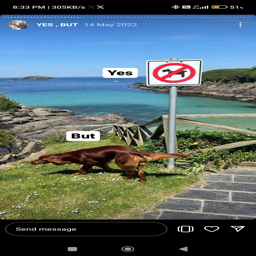

 This image is funny because it shows a dog peeing on a sign that says "No dogs allowed". The contrast between the sign and the dog's action is humorous because its unexpected. Thus, my answer is Y.


In [2]:
import random, json
from PIL import Image
import os

outputfile = "outputs/detection/gemini-cot-real.json"
with open(outputfile, "r") as f:
    outputs = json.load(f)

image_path = random.choice(list(outputs.keys()))
output = outputs[image_path]
#assert ("left" in outputfile) == ("YES" in image_path)
display(Image.open(image_path).convert('RGB').resize((256,256)))
print(output)

# Completion stats

In [17]:
import json
with open("completion_groundtruth.json", "r") as f:
    gt = json.load(f)
with open("outputs/completion/llava-cot-full.json", "r") as f:
    real = json.load(f)
    
def clean_value(value):
    """Clean the prediction or ground truth value."""
    value = value.strip().replace('"', '')  # Strip spaces and quotes
    if len(value) >= 2:
        if value[-3] in ["A", "B"]:
            value = value[-3]
        elif value[-2] in ["A", "B"]:
            value = value[-2]  # Take the pred[-2] character if length > 3
        elif value[-1] in ["A", "B"]:
            value = value[-1]
    return value

def evaluate_performance(preds, ground_truths):

    # Initialize counters for true positives, false positives, true negatives, and false negatives
    tp, fp, tn, fn = 0, 0, 0, 0

    for key in preds:
        if not preds[key]:
            continue
        pred = clean_value(preds[key])
        true = clean_value(ground_truths[key])
        
        if pred == 'A' and true == 'A':
            tp += 1
        elif pred == 'A' and true == 'B':
            fp += 1
        elif pred == 'B' and true == 'B':
            tn += 1
        elif pred == 'B' and true == 'A':
            fn += 1

    # Calculate metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    precisionA = tp / (tp + fp) if (tp + fp) > 0 else 0
    precisionB = tn / (tn + fn) if (tn + fn) > 0 else 0
    recallA = tp / (tp + fn) if (tp + fn) > 0 else 0
    recallB = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1A = 2 * (precisionA * recallA) / (precisionA + recallA) if (precisionA + recallA) > 0 else 0
    f1B = 2 * (precisionB * recallB) / (precisionB + recallB) if (precisionB + recallB) > 0 else 0

    macro_avg_precision = (precisionA+precisionB)/2
    weighted_avg_precision = (precisionA*(tp+fn)+precisionB*(tn+fp))/(tp+fp+tn+fn)

    macro_avg_recall = (recallA+recallB)/2
    weighted_avg_recall = (recallA*(tp+fn)+recallB*(tn+fp))/(tp+fp+tn+fn)  # should be same as accuracy

    macro_avg_f1 = (f1A+f1B)/2
    weighted_avg_f1 = (f1A*(tp+fn)+f1B*(tn+fp))/(tp+fp+tn+fn)
    
    # Print out the metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"A/B: {tp+fp}/{tn+fn}")
    print(f"Precision : (A): {precisionA:.4f}, (B): {precisionB:.4f}, (macro): {macro_avg_precision:.4f}, (weighted): {weighted_avg_precision:.4f}")
    print(f"Recall : (A): {recallA:.4f}, (B): {recallB:.4f}, (macro): {macro_avg_recall:.4f}, (weighted): {weighted_avg_recall:.4f}")
    print(f"F1 Score : (A): {f1A:.4f}, (B): {f1B:.4f}, (macro): {macro_avg_recall:.4f}, (wieghted): {weighted_avg_f1:.4f}")

# Example usage
#preds = {"1": " A", "2": "\"B\"", "3": "CAB", "4": " BA "}
#ground_truths = {"1": "A", "2": "B", "3": "A", "4": "B"}

evaluate_performance(real, gt)

Accuracy: 0.5655
A/B: 58/87
Precision : (A): 0.4483, (B): 0.6437, (macro): 0.5460, (weighted): 0.5669
Recall : (A): 0.4561, (B): 0.6364, (macro): 0.5463, (weighted): 0.5655
F1 Score : (A): 0.4522, (B): 0.6400, (macro): 0.5463, (wieghted): 0.5662


In [ ]:
print(set(real.values()))
stats = {True: {"A": 0, "B": 0}, False: {"A": 0, "B": 0}}
for file,pred in real.items():
    pred = pred.strip('"')
    stats[pred==gt[file]][pred]+=1

print(stats)
nA_gt = sum(1 for r in gt.values() if r=="A")
print(f"gt A,B: {nA_gt, len(gt)-nA_gt}")
print(f"pred A,B: {sum(1 for r in real.values() if r=='A'), len(gt)-sum(1 for r in real.values() if r=='A')}")
print(f"accuracy: {sum(stats[True].values())/sum(sum(v.values()) for v in stats.values())}")
print(f"recallA: {stats[True]['A']/nA_gt}")
print(f"recallB: {stats[True]['B']/(len(gt)-nA_gt)}")

In [46]:
92/(92+58)

0.6133333333333333

## GPT4-Vision
### Zero shot
- (A,B) = (26, 124)
- Accuracy: 0.5867
- Precision : (A): 0.4231, (B): 0.6210, (macro): 0.5220, (weighted): 0.5444
- Recall : (A): 0.1897, (B): 0.8370, (macro): 0.5133, (weighted): 0.5867
- F1 Score : (A): 0.2619, (B): 0.7130, (macro): 0.5133, (wieghted): 0.5386

### COT
- (A,B) = (16, 134)
- Accuracy: 0.5733
- Precision : (A): 0.3125, (B): 0.6045, (macro): 0.4585, (weighted): 0.4916
- Recall : (A): 0.0862, (B): 0.8804, (macro): 0.4833, (weighted): 0.5733
- F1 Score : (A): 0.1351, (B): 0.7168, (macro): 0.4833, (wieghted): 0.4919

## Gemini
### Zero Shot
prompt = '''You are an AI expert in creating humour or satire. User gives you an image, and you have to make a choice "A" or "B".
###Instructions: The image is a 2x2 table with the labels "yes" (top left), "but" (top right), "A" (bottom left), and "B" (bottom right). Either the "yes" cell or the "but" cell will have a question mark in it. Your job is to replace the question mark with either cell "A" or cell "B" so that the resulting [yes,but] pair is funny or satirical. Make a choice  "A" or "B":
###Output format: one character, exactly either "A" or "B"'''
- Accuracy: 0.6111
- A/B: 37/107
- Precision : (A): 0.4595, (B): 0.6636, (macro): 0.5615, (weighted): 0.5884
- Recall : (A): 0.3208, (B): 0.7802, (macro): 0.5505, (weighted): 0.6111
- F1 Score : (A): 0.3778, (B): 0.7172, (macro): 0.5505, (wieghted): 0.5923

### COT
prompt = '''You are an AI expert in creating humour or satire. User gives you an image, and you have to make a choice "A" or "B".
###Instructions: The image is a 2x2 table with the labels "yes" (top left), "but" (top right), "A" (bottom left), and "B" (bottom right). Either the "yes" cell or the "but" cell will have a question mark in it. Your job is to replace the question mark with either cell "A" or cell "B" so that the resulting [yes,but] pair is funny or satirical. Make a choice  "A" or "B":
###Output format:
"If question mark is replaced by option A, the image <will/will not> be funny because <one sentence>.
If question mark is replaced by option B, the image <will/will not> be funny because <one sentence>.
Hence, option <answer> is more funny and the answer is <answer>", where <answer> is either A or B'''

- Accuracy: 0.6181
- A/B: 14/130
- Precision : (A): 0.4286, (B): 0.6385, (macro): 0.5335, (weighted): 0.5612
- Recall : (A): 0.1132, (B): 0.9121, (macro): 0.5126, (weighted): 0.6181
- F1 Score : (A): 0.1791, (B): 0.7511, (macro): 0.5126, (wieghted): 0.5406

## LLaVa
### Zero Shot
- Accuracy: 0.5133
- A/B: 67/83
- Precision : (A): 0.3881, (B): 0.6145, (macro): 0.5013, (weighted): 0.5269
- Recall : (A): 0.4483, (B): 0.5543, (macro): 0.5013, (weighted): 0.5133
- F1 Score : (A): 0.4160, (B): 0.5829, (macro): 0.5013, (wieghted): 0.5183

### COT
prompt = "Choose the correct option from A (bottom left) or B (bottom right), so that when the question mark is replaced by this option, the resulting top row is funny/satirical"
nudge 1 = "Lets think step by step. There are 4 quadrants - top left, top right, bottom left (A) and bottom right (B). The top left image consists of "
nudge 2 = ". Hence the correct option out of [A]/[B] is ["
- Accuracy: 0.5655
- A/B: 58/87
- Precision : (A): 0.4483, (B): 0.6437, (macro): 0.5460, (weighted): 0.5669
- Recall : (A): 0.4561, (B): 0.6364, (macro): 0.5463, (weighted): 0.5655
- F1 Score : (A): 0.4522, (B): 0.6400, (macro): 0.5463, (wieghted): 0.5662


# Detection Stats

In [9]:
import json

outfile = "outputs/detection/gemini-cot-real.json"
with open(outfile, "r") as f:
    outputs = json.load(f)

def get_pred(current_model, output):
    if "llava-cot" in current_model:
        return output["pred"][0]
    if "llava" in current_model:
        return output[0]
    if "gemini" in current_model:
        if not output:
            return ""
        return output.strip(' .*')[-1]
    if "gpt4-vision-cot" in current_model:
        if not output:
            return ""
        return output[-2]
    if "gpt" in current_model:
        if not output:
            return ""
        return output[0]

def is_correct(pred, folder):
    if not pred:
        return False
    return pred=="Y"
            
def calculate_stats(output_json):
    bad = []
    ty, fy, tn, fn = 0,0,0,0
    correct = 0
    for filepath, output in output_json.items():
        pred = get_pred(outfile, output)
        if pred not in ["Y", "N"]:
            print(f"Found bad: {output}")
            pred = input("Enter only Y/N")
            bad.append(output)
        if pred=="Y" and is_correct(pred, filepath.split('/')[0]):
            ty+=1
            continue
        if pred=="Y":
            fy+=1
        if pred=="N" and is_correct(pred, filepath.split('/')[0]):
            tn+=1
            continue
        if pred=="N":
            fn+=1
    print("bad: ", len(bad))
    #print(bad[0])

    assert ty+fy+tn+fn==len(output_json)
    accuracy = (ty+tn)/(ty+tn+fy+fn)
    
    precision_y = ty/(ty+fy)
    precision_n = tn/(tn+fn)
    precision_macro = (precision_y+precision_n)/2
    precision_weighted = (precision_y*(ty+fn)+precision_n*(tn+fy))/(ty+tn+fy+fn)
    
    recall_y = ty/(ty+fn)
    recall_n = tn/(tn+fy) if tn+fy>0 else 0
    recall_macro = (recall_n+recall_y)/2
    recall_weighted = (recall_y*(ty+fn)+recall_n*(tn+fy))/(ty+tn+fy+fn)

    def f1(p,r):
        return 2*p*r/(p+r) if p+r>0 else 0
    f1_y = f1(precision_y, recall_y)
    f1_n  = f1(precision_n, recall_n)
    f1_macro = (f1_y+f1_n)/2
    f1_weighted = (f1_y*(ty+fn)+f1_n*(tn+fy))/(ty+tn+fy+fn)

    
    return {"precision": precision_y,
            "recall": recall_y,
            "f1": f1_y,
            "accuracy": accuracy,
            "y%": (ty+fy)/(ty+fy+tn+fn)
           }


# for source_folder in ["images_real"]:
#     filtered_outputs = {x:y for x,y in outputs.items() if source_folder in x}
#     print(f"#### Round: {source_folder}, total: {len(filtered_outputs)}")
#     print(calculate_stats(filtered_outputs))
# print("#### Overall total: 2547")
print(calculate_stats(outputs))

Found bad:  The image shows a meme with 2 panels. The first panel says "No war" in Russian language and shows a frozen river with a large crack in it, and a boat getting trapped in it. The text "no war" is referring to Russian invasion of Ukraine. The second panel show a man painting over the cracks in the ice, but the text "no war" can still be seen.

Overall, the image is trying to convey the message that while the war in Ukraine has led to a lot of suffering, it has also brought people together to support the country and its people.


Enter only Y/N N


Found bad:  The image is not funny because it is not a meme.

The image is a still shot of a laptop screen and a TV showing similar images side by side. The only difference between the images is that the version on the laptop says "YES" while the TV version says "BUT". Neither half of the image is particularly funny, and there are no elements in the surrounding environment that would make the image funnier.


Enter only Y/N N


bad:  2
{'precision': 1.0, 'recall': 0.8067226890756303, 'f1': 0.8930232558139535, 'accuracy': 0.8067226890756303, 'y%': 0.8067226890756303}


## Llava

### Zero shot
#### Round: images, total: 283
{'precision': [1.0, 0.0, 0.5, 1.0], 'recall': [0.254416961130742, 0, 0.127208480565371, 0.254416961130742], 'f1': [0.40563380281690137, 0, 0.20281690140845068, 0.40563380281690137], 'accuracy': 0.254416961130742, 'y%': 0.254416961130742}
#### Round: second, total: 849
{'precision': [0.34210526315789475, 0.6392914653784219, 0.49069836426815827, 0.5335785877923215], 'recall': [0.2582781456953642, 0.7257769652650823, 0.49202755548022326, 0.5594817432273262], 'f1': [0.2943396226415095, 0.6797945205479452, 0.48706707159472734, 0.5426833554504852], 'accuracy': 0.5594817432273262, 'y%': 0.26855123674911663}
#### Round: third, total: 1415
{'precision': [0.36885245901639346, 0.6530028598665396, 0.5109276594414666, 0.5527971708034846], 'recall': [0.27054108216432865, 0.7478165938864629, 0.5091788380253958, 0.5795053003533569], 'f1': [0.31213872832369943, 0.6972010178117048, 0.5046698730677022, 0.5614087333915532], 'accuracy': 0.5795053003533569, 'y%': 0.25865724381625443}
#### Overall total: 2547
{'precision': [0.42792792792792794, 0.5752259436469963, 0.5015769357874621, 0.5125360932192499], 'recall': [0.2629151291512915, 0.7395762132604238, 0.5012456712058576, 0.5367098547310561], 'f1': [0.32571428571428573, 0.6471291866028708, 0.48642173615857826, 0.5103354086039599], 'accuracy': 0.5367098547310561, 'y%': 0.26148409893992935}

### COT
#### Round: images, total: 283
{'precision': [1.0, 0.0, 0.5, 1.0], 'recall': [0.30742049469964666, 0, 0.15371024734982333, 0.30742049469964666], 'f1': [0.4702702702702703, 0, 0.23513513513513515, 0.47027027027027035], 'accuracy': 0.30742049469964666, 'y%': 0.30742049469964666}
#### Round: second, total: 849
{'precision': [0.2825112107623318, 0.6182108626198083, 0.4503610366910701, 0.49879826561043505], 'recall': [0.20860927152317882, 0.7074954296160878, 0.45805235056963334, 0.5300353356890459], 'f1': [0.24, 0.659846547314578, 0.449923273657289, 0.5105018390825373], 'accuracy': 0.5300353356890459, 'y%': 0.2626619552414605}
#### Round: third, total: 1415
{'precision': [0.3217391304347826, 0.6373831775700934, 0.47956115400243804, 0.5260712485803266], 'recall': [0.22244488977955912, 0.7445414847161572, 0.48349318724785817, 0.5604240282685512], 'f1': [0.2630331753554502, 0.6868076535750252, 0.4749204144652377, 0.5373635089590761], 'accuracy': 0.5604240282685512, 'y%': 0.24381625441696114}
#### Overall total: 2547
{'precision': [0.3984732824427481, 0.5650105708245243, 0.48174192663363624, 0.4941325101233679], 'recall': [0.24077490774907748, 0.7306903622693096, 0.48573263500919356, 0.5221829603455045], 'f1': [0.30017251293847036, 0.6372578241430701, 0.4687151685407702, 0.4937947392016543], 'accuracy': 0.5221829603455045, 'y%': 0.2571652925009815}
### Round: real, total: 119
{'precision': 1.0, 'recall': 0.18487394957983194, 'f1': 0.3120567375886525, 'accuracy': 0.18487394957983194, 'y%': 0.18487394957983194}


## Gemini

### Zero Shot
#### Round: images, total: 283
{'precision': [1.0, 0.0, 0.5, 1.0], 'recall': [0.9244604316546763, 0, 0.46223021582733814, 0.9244604316546763], 'f1': [0.9607476635514018, 0, 0.4803738317757009, 0.960747663551402], 'accuracy': 0.9244604316546763, 'y%': 0.9244604316546763}
#### Round: second, total: 849
{'precision': [0.3962558502340094, 0.7578947368421053, 0.5770752935380573, 0.6273391821099407], 'recall': [0.8466666666666667, 0.2711864406779661, 0.5589265536723164, 0.4789410348977136], 'f1': [0.5398512221041445, 0.39944521497919555, 0.46964821854167005, 0.45013330419397857], 'accuracy': 0.4789410348977136, 'y%': 0.7713598074608905}
#### Round: third, total: 1415
{'precision': [0.3686165273909007, 0.7029702970297029, 0.5357934122103019, 0.5849773362948502], 'recall': [0.8151950718685832, 0.23852183650615902, 0.5268584541873711, 0.4420289855072464], 'f1': [0.5076726342710999, 0.3561872909698997, 0.43192996262049976, 0.40964624907691743], 'accuracy': 0.4420289855072464, 'y%': 0.7804347826086957}
#### Overall total: 2547
{'precision': [0.45974683544303796, 0.6945525291828794, 0.5771496823129587, 0.5940832387718986], 'recall': [0.8525821596244132, 0.25070224719101125, 0.5516422034077122, 0.5082362394535959], 'f1': [0.5973684210526315, 0.368421052631579, 0.48289473684210527, 0.46638366708253154], 'accuracy': 0.5082362394535959, 'y%': 0.7934913619927682}


### COT
#### Round: images, total: 283
{'precision': [1.0, 0.0, 0.5, 1.0], 'recall': [0.9671532846715328, 0, 0.4835766423357664, 0.9671532846715328], 'f1': [0.9833024118738405, 0, 0.49165120593692024, 0.9833024118738405], 'accuracy': 0.9671532846715328, 'y%': 0.9671532846715328}
#### Round: second, total: 849
{'precision': [0.3771353482260184, 0.8620689655172413, 0.6196021568716299, 0.6873981265661904], 'recall': [0.9728813559322034, 0.09541984732824428, 0.5341506016302239, 0.41147741147741146], 'f1': [0.5435606060606061, 0.17182130584192443, 0.35769095595126527, 0.3057200769829636], 'accuracy': 0.41147741147741146, 'y%': 0.9291819291819292}
#### Round: third, total: 1415
{'precision': [0.3613109512390088, 0.71875, 0.5400304756195045, 0.5922596042093085], 'recall': [0.9262295081967213, 0.10325476992143659, 0.514742139059079, 0.3944887599709935], 'f1': [0.5198389879240942, 0.18056918547595682, 0.3502040867000255, 0.3006298552328031], 'accuracy': 0.3944887599709935, 'y%': 0.9071791153009428}
#### Overall total: 2547
{'precision': [0.4409310496267018, 0.7282051282051282, 0.584568088915915, 0.605369893149547], 'recall': [0.9498580889309366, 0.10035335689045936, 0.525105722910698, 0.46359223300970875], 'f1': [0.6022795440911817, 0.17639751552795033, 0.389338529809566, 0.35849998486101486], 'accuracy': 0.46359223300970875, 'y%': 0.9211165048543689}
#### Round: real, total: 119
{'precision': 1.0, 'recall': 0.8067226890756303, 'f1': 0.8930232558139535, 'accuracy': 0.8067226890756303, 'y%': 0.8067226890756303}

## GPT4 Vision

### Zero Shot
#### Round: images, total: 283
{'precision': [1.0, 0.0, 0.5, 1.0], 'recall': [0.9257950530035336, 0, 0.4628975265017668, 0.9257950530035336], 'f1': [0.9614678899082569, 0, 0.48073394495412847, 0.961467889908257], 'accuracy': 0.9257950530035336, 'y%': 0.9257950530035336}
#### Round: second, total: 849
{'precision': [0.3889845094664372, 0.7153558052434457, 0.5521701573549415, 0.5991245183039922], 'recall': [0.7483443708609272, 0.3498168498168498, 0.5490806103388886, 0.49174528301886794], 'f1': [0.5118912797281994, 0.4698646986469865, 0.49087798918759296, 0.48483171219241844], 'accuracy': 0.49174528301886794, 'y%': 0.6851415094339622}
#### Round: third, total: 1415
{'precision': [0.3891566265060241, 0.7003424657534246, 0.5447495461297244, 0.5907451899788805], 'recall': [0.6485943775100401, 0.4465065502183406, 0.5475504638641904, 0.5176803394625177], 'f1': [0.4864457831325302, 0.5453333333333333, 0.5158895582329317, 0.5245935879302216], 'accuracy': 0.5176803394625177, 'y%': 0.5869872701555869}
#### Overall total: 2547
{'precision': [0.4847579199043634, 0.6880733944954128, 0.5864156571998881, 0.6015544715161961], 'recall': [0.7488457987072945, 0.4103967168262654, 0.57962125776678, 0.5544204322200393], 'f1': [0.5885341074020319, 0.5141388174807198, 0.5513364624413759, 0.5457970096161937], 'accuracy': 0.5544204322200393, 'y%': 0.6573673870333988}

### COT
#### Round: images, total: 283
{'precision': [1.0, 0.0, 0.5, 1.0], 'recall': [0.9929328621908127, 0, 0.49646643109540634, 0.9929328621908127], 'f1': [0.9964539007092198, 0, 0.4982269503546099, 0.9964539007092197], 'accuracy': 0.9929328621908127, 'y%': 0.9929328621908127}
#### Round: second, total: 849
{'precision': [0.37548387096774194, 0.8493150684931506, 0.6123994697304462, 0.6805685806951867], 'recall': [0.9635761589403974, 0.11355311355311355, 0.5385646362467554, 0.41627358490566035], 'f1': [0.5403899721448467, 0.20032310177705978, 0.3703565369609533, 0.32143182212030463], 'accuracy': 0.41627358490566035, 'y%': 0.9139150943396226}
#### Round: third, total: 1415
{'precision': [0.3689795918367347, 0.7566137566137566, 0.5627966742252457, 0.6200919644928535], 'recall': [0.9076305220883534, 0.15611353711790393, 0.5318720296031286, 0.4207920792079208], 'f1': [0.5246662797446314, 0.2588235294117647, 0.39174490457819805, 0.3524513155968903], 'accuracy': 0.4207920792079208, 'y%': 0.8663366336633663}
#### Overall total: 2547
{'precision': [0.448925909688733, 0.7765151515151515, 0.6127205306019423, 0.6371127354452061], 'recall': [0.9455216989843028, 0.140218878248974, 0.5428702886166384, 0.48290766208251473], 'f1': [0.6087990487514863, 0.23754345307068364, 0.423171250911085, 0.3955276613702158], 'accuracy': 0.48290766208251473, 'y%': 0.8962671905697446}
#### Round: real, total: 119
{'precision': 1.0, 'recall': 0.9327731092436975, 'f1': 0.9652173913043478, 'accuracy': 0.9327731092436975, 'y%': 0.9327731092436975}